## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from skimage import io
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50  #do not work for keras 2.2.4, change it to
# from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import sklearn.metrics as metrics
import seaborn as sns
import random

Using TensorFlow backend.


In [2]:
# random seed
random.seed(21)
np.random.seed(21)

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
99818,00026444_001.png,No Finding,1,26444,81,M,PA,2992,2991,0.143,0.143,NaN,/data/images_011/images/00026444_001.png
31515,00008232_018.png,Emphysema|Infiltration,18,8232,41,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008232_018.png
90941,00022663_000.png,No Finding,0,22663,55,M,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00022663_000.png


In [4]:
# Drop the records that 'Patient Age' >= 100
all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] >= 100].index, inplace = True)

In [5]:
len(all_xray_df)

112104

In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# Todo
# Use all_labels to store the unique labels
all_labels  =np.unique(list(chain(*all_xray_df['Finding Labels'].str.split('|'))))
all_labels = [x for x in all_labels if len(x) > 0]
# create extrax columns of booleans to represent if certain disease if found
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].str.contains(label, regex = False)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
34198,00008964_003.png,Mass,3,8964,56,F,AP,2500,2048,0.171,...,False,False,False,False,True,False,False,False,False,False
6764,00001819_003.png,Atelectasis,3,1819,49,M,PA,3056,2544,0.139,...,False,False,False,False,False,False,False,False,False,False
9053,00002371_011.png,No Finding,11,2371,38,M,AP,2500,2048,0.168,...,False,False,False,False,False,True,False,False,False,False
111166,00030342_001.png,No Finding,1,30342,36,F,AP,3056,2544,0.139,...,False,False,False,False,False,True,False,False,False,False
94770,00024497_000.png,No Finding,0,24497,31,M,PA,2738,2989,0.143,...,False,False,False,False,False,True,False,False,False,False


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 1 if x else 0).astype(str)
# Todo

In [8]:
# calculate the ratio of 'Pneumonia' positive samples
len(all_xray_df[all_xray_df['Pneumonia']  == True]) / len(all_xray_df[all_xray_df['Pneumonia'] == False])

0.012920830547373367

In [9]:
target_col = 'pneumonia_class'

In [10]:
len(np.unique(all_xray_df['Patient ID']))

30802

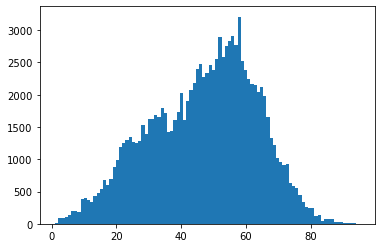

In [11]:
# plot the age distribution of 'Patient Age'
patient_age = plt.hist(all_xray_df['Patient Age'], bins = 'auto')

In [12]:
all_xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

## Create your training and testing data:

To prevent data leakage, we split patients to different groups according to 'Patient ID', split all patient_id into 3 groups: train, valid and test with weights 8:1:1.

In [13]:
patient_id_df = all_xray_df.groupby(['Patient ID'])['Image Index'].agg(
    lambda x: tuple([y for y in x if y is not np.nan ] ) ).reset_index()
patient_id_df['group'] = np.random.choice(3, len(patient_id_df), p = [0.8, 0.1, 0.1])
train_patient_id = set(patient_id_df[patient_id_df['group'] == 0]['Patient ID'])
valid_patient_id = set(patient_id_df[patient_id_df['group'] == 1]['Patient ID'])
test_patient_id = set(patient_id_df[patient_id_df['group'] == 2]['Patient ID'])
len(train_patient_id), len(valid_patient_id), len(test_patient_id)

(24728, 3053, 3021)

In [14]:
train_data = all_xray_df[all_xray_df['Patient ID'].isin(train_patient_id)]
valid_data = all_xray_df[all_xray_df['Patient ID'].isin(valid_patient_id)]
test_data = all_xray_df[all_xray_df['Patient ID'].isin(test_patient_id)]
len(train_data), len(valid_data), len(test_data)

(90957, 10653, 10494)

In [15]:
def data_ratio(data, col, value):
    """
    return the ratio of data that data[col] = value
    """
    return len(data[data[col] == value]) / len(data)

def drop_data(data, col, value, expect_ratio):
    """
    drop data of data[col] == value to expect_ratio if the current ratio > expect_ratio
    """
    curr_ratio = data_ratio(data, col, value)
    counts = int((curr_ratio - expect_ratio)/(1 - expect_ratio) * len(data))
    if counts <= 0:
        return
    dropped_idx = np.random.choice(data[data[col] == value].index, counts, replace = False)
    return data.drop(dropped_idx)

In [16]:
# 'Pneumonia' positive ratio in train_data, valid_data, and test_data
print([data_ratio(_d, 'Pneumonia', True) for _d in [train_data, valid_data, test_data]])

[0.012918192112756577, 0.011827654181920586, 0.012292738707833047]


In [17]:
train_data = drop_data(train_data, 'Pneumonia', False, 0.5) 
valid_data = drop_data(valid_data, 'Pneumonia', False, 0.8)
test_data = drop_data(test_data, 'Pneumonia', False, 0.8)

In [18]:
len(train_data), len(valid_data), len(test_data)

(2350, 630, 646)

In [19]:
print([data_ratio(_d, 'Pneumonia', True) for _d in [train_data, valid_data, test_data]])

[0.5, 0.2, 0.1996904024767802]


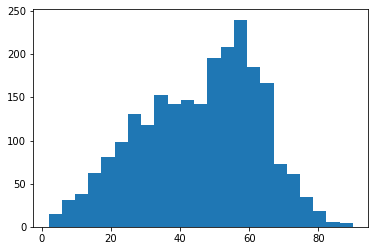

In [20]:
train_data_age = plt.hist(train_data['Patient Age'], bins = 'auto')

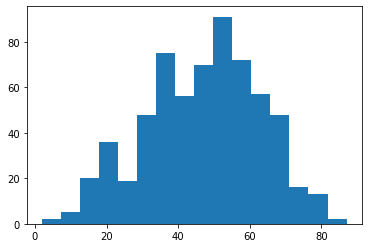

In [21]:
valid_data_age = plt.hist(valid_data['Patient Age'], bins = 'auto')

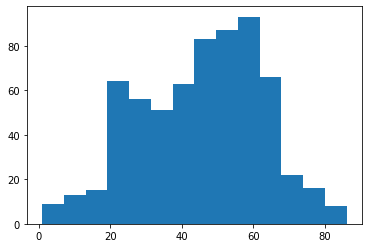

In [22]:
test_data_age = plt.hist(test_data['Patient Age'], bins = 'auto')

In [23]:
print([data_ratio(_d, 'Patient Gender', 'M') for _d in [train_data, valid_data, test_data]])

[0.5761702127659575, 0.546031746031746, 0.5743034055727554]


In [24]:
train_data['Patient Age'].describe()

count    2350.000000
mean       45.664255
std        17.142903
min         2.000000
25%        33.000000
50%        48.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

In [25]:
valid_data['Patient Age'].describe()

count    630.000000
mean      47.042857
std       16.102308
min        2.000000
25%       36.000000
50%       48.000000
75%       59.000000
max       87.000000
Name: Patient Age, dtype: float64

In [26]:
test_data['Patient Age'].describe()

count    646.000000
mean      45.524768
std       16.935862
min        1.000000
25%       32.000000
50%       47.000000
75%       59.000000
max       86.000000
Name: Patient Age, dtype: float64

We see age and gender distribution of train_data, valid_data and test_data similar to the original data seet. No need to ajust their distribution.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [28]:
# image generator for training data
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                          samplewise_center=True, 
                          samplewise_std_normalization=True, 
                          horizontal_flip = True, 
                          height_shift_range= 0.1, 
                          width_shift_range=0.1, 
                          rotation_range=10,
                          shear_range = 0.1,
                          zoom_range=0.1)

# image generator for valid data and test data
val_idg = ImageDataGenerator(rescale = 1/ 255.0, 
                             samplewise_center=True, 
                              samplewise_std_normalization=True
                            )
IMG_SIZE = (224, 224)

In [29]:
def make_data_gen(idg, dataframe, directory, x_col, y_col, batch_size):
    """
    data generator with image generator idg
    """
    data_gen = idg.flow_from_dataframe(dataframe=dataframe, 
                             directory=directory, 
                             x_col = x_col,
                             y_col = y_col,
                             class_mode = 'binary',
                             target_size = IMG_SIZE, 
                             batch_size = batch_size
                             )
    return data_gen

In [30]:
train_batch_size = 24
train_gen = make_data_gen(train_idg , train_data, None, 'path', target_col, train_batch_size)

Found 2350 validated image filenames belonging to 2 classes.


In [31]:
val_batch_size = 50
val_gen = make_data_gen(val_idg , valid_data, None, 'path', target_col, val_batch_size)
val_steps = len(valid_data) // val_batch_size

Found 630 validated image filenames belonging to 2 classes.


0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0


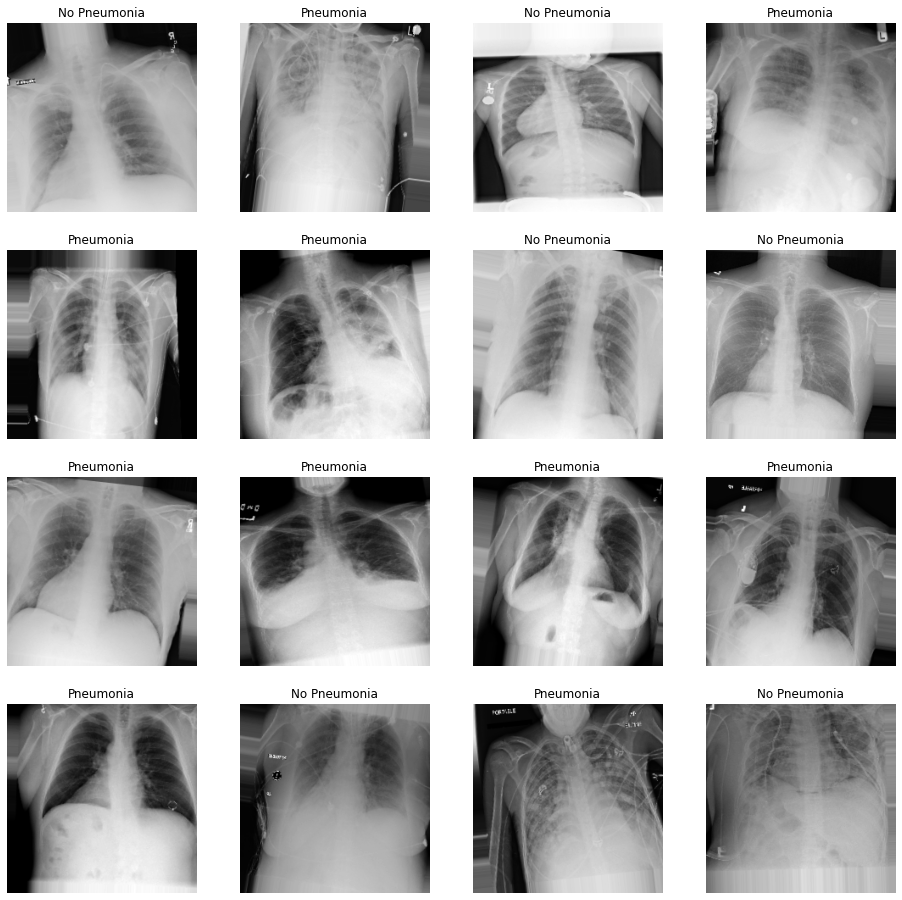

In [32]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    print(c_y)
    c_ax.imshow(c_x[:,:,0], cmap = 'gray')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [61]:
tf.keras.backend.clear_session()

In [62]:
def load_pretrained_model(lay_of_interests):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interests)
    pretrained_model = Model(inputs = model.input, outputs = transfer_layer.output)
    # Freeze layers
    for layer in pretrained_model.layers[0:17]:
        layer.trainable = False
    return pretrained_model

In [63]:
pretrained_model = load_pretrained_model('block5_pool')

553467904/553467096 [==============================] - 8s 0us/step


In [64]:
def build_my_model(pre_trained_model, optimizer, loss, metrics):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    drop_out_ratio = 0.5
    new_model = Sequential()
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(pre_trained_model)
    # Flatten the output of the VGG16 model because it is from a convolutional layer.
    new_model.add(Flatten())
    new_model.add(Dropout(drop_out_ratio))

    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(drop_out_ratio))

    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(drop_out_ratio))

    new_model.add(Dense(256, activation='relu'))

    new_model.add(Dropout(drop_out_ratio))

    new_model.add(Dense(128, activation='relu'))

    new_model.add(Dense(1, activation='sigmoid'))
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return new_model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [65]:
my_model = build_my_model(pretrained_model, Adam(lr=1e-4), 'binary_crossentropy', ['accuracy'])

In [66]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting
# Todo
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

In [64]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

### Start training! 

In [66]:
history = my_model.fit_generator(train_gen, validation_data = val_gen, validation_steps = val_steps,
                                 epochs = 40, callbacks = callbacks_list)

Epoch 1/40
98/98 [==============================] - 85s 867ms/step - loss: 0.8259 - accuracy: 0.5085 - val_loss: 0.6958 - val_accuracy: 0.4367

Epoch 00001: val_loss improved from inf to 0.69582, saving model to xray_class_my_model.best.hdf5
Epoch 2/40
98/98 [==============================] - 70s 712ms/step - loss: 0.7239 - accuracy: 0.5272 - val_loss: 0.6754 - val_accuracy: 0.5638

Epoch 00002: val_loss improved from 0.69582 to 0.67544, saving model to xray_class_my_model.best.hdf5
Epoch 3/40
98/98 [==============================] - 68s 692ms/step - loss: 0.7091 - accuracy: 0.5289 - val_loss: 0.6448 - val_accuracy: 0.7241

Epoch 00003: val_loss improved from 0.67544 to 0.64482, saving model to xray_class_my_model.best.hdf5
Epoch 4/40
98/98 [==============================] - 68s 690ms/step - loss: 0.6624 - accuracy: 0.6217 - val_loss: 0.6767 - val_accuracy: 0.6500

Epoch 00007: val_loss did not improve from 0.56826
Epoch 8/40
98/98 [==============================] - 67s 687ms/step - lo

In [67]:
# save the training history to a csv file
pd.DataFrame(history.history).to_csv('history.csv')

In [68]:
len(test_data)

646

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [33]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
# generate the test_data
test_gen = make_data_gen(val_idg , test_data, None, 'path', target_col, len(test_data))
my_model.load_weights(weight_path)
# my_model = load_model('my_model.h5')  #load model from saved file
testX, testY = test_gen.next()
test_batch_size = 50
pred_Y = my_model.predict(testX, batch_size = test_batch_size, verbose = True)

Found 646 validated image filenames belonging to 2 classes.
646/646 [==============================] - 17s 26ms/step


In [37]:
# save history record and the training model
history_record = pd.DataFrame(history.history)
# history_record = pd.read_csv('history.csv')
# history_record.to_csv('history.csv')
# my_model.save('my_model.h5')

In [34]:
# Todo
#Also consider plotting the history of your model training:
# Functions to plot loss and accuracy in history_record
def plot_history_loss(record):
    N = len(record)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), record["loss"], label="train_loss")
    plt.plot(np.arange(0, N), record["val_loss"], label="val_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.ylim(0,1)
    return

def plot_history_accuracy(record):
    N = len(record)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), record["accuracy"], label="train_auc")
    plt.plot(np.arange(0, N), record["val_accuracy"], label="val_auc")
    plt.title("Training Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    plt.ylim(0,1)
    return

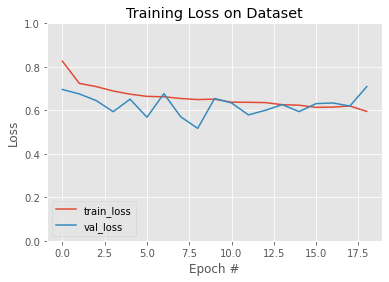

In [38]:
# plot loss of train_loss and val_loss
plot_history_loss(history_record)

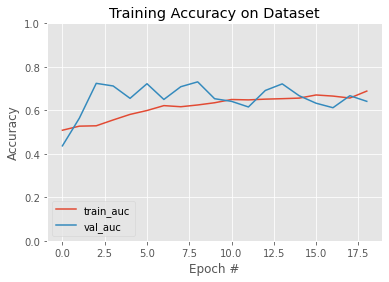

In [39]:
# plot loss of train_auc and val_auc
plot_history_accuracy(history_record)

In [41]:
def plot_auc(test_vals, predict_vals):
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    # Todo
    """
    plot roc curve and calculate auc of roc
    """
    fpr, tpr, threshold = metrics.roc_curve(test_vals, predict_vals)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.ylabel('True Positive Rate')
    plt.xlabel('Flase Positive Rate')
    plt.show()    
    return fpr, tpr, roc_auc

## what other performance statistics do you want to include here besides AUC? 
def plot_precision_recall_curve(test_vals, predict_vals):
    """
    plot precsion recall curve
    """
    precision, recall, thresholds = metrics.precision_recall_curve(test_vals, predict_vals)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()    
    return

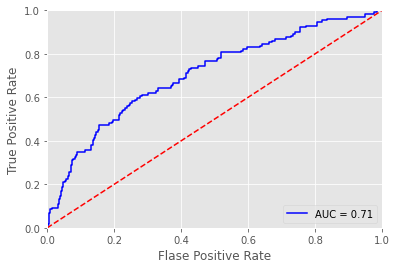

(array([0.        , 0.        , 0.00193424, 0.00193424, 0.00580271,
        0.00580271, 0.00967118, 0.00967118, 0.01353965, 0.01353965,
        0.03288201, 0.03288201, 0.03481625, 0.03481625, 0.03675048,
        0.03675048, 0.03868472, 0.03868472, 0.04255319, 0.04255319,
        0.04448743, 0.04448743, 0.04642166, 0.04642166, 0.05415861,
        0.05415861, 0.05609284, 0.05609284, 0.06189555, 0.06189555,
        0.06576402, 0.06576402, 0.0696325 , 0.0696325 , 0.07156673,
        0.07156673, 0.0754352 , 0.0754352 , 0.07736944, 0.07736944,
        0.08317215, 0.08317215, 0.08510638, 0.08510638, 0.08897485,
        0.08897485, 0.11411992, 0.11411992, 0.13152805, 0.13152805,
        0.13539652, 0.13539652, 0.13926499, 0.13926499, 0.14313346,
        0.14313346, 0.14700193, 0.14700193, 0.15280464, 0.15280464,
        0.15473888, 0.15473888, 0.18568665, 0.18568665, 0.1934236 ,
        0.1934236 , 0.19729207, 0.19729207, 0.21470019, 0.21470019,
        0.21856867, 0.21856867, 0.22243714, 0.22

In [42]:
plot_auc(testY, pred_Y)

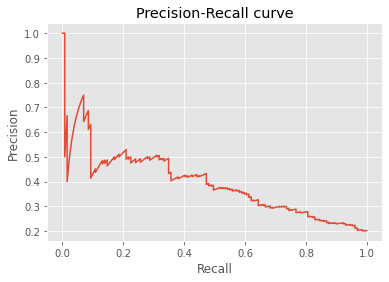

In [43]:
plot_precision_recall_curve(testY, pred_Y)

In [44]:
def evaluate_model(t_y, p_y, threshold):
    """
    evaluate the performance of model with the given threshold, 
    return threshold, accuracy, precision, recall and F1.
    """
    pred_label = [1 if score >= threshold else 0 for score in p_y]
    accuracy = metrics.accuracy_score(t_y, pred_label)
    precision = metrics.precision_score(t_y, pred_label, pos_label=1,zero_division = 1)
    recall = metrics.recall_score(t_y, pred_label, pos_label=1)
    F1 = metrics.f1_score(t_y, pred_label, pos_label=1)
    return pd.Series([threshold, accuracy, precision, recall, F1])

In [45]:
# use a dataframe to show 'Accuracy', 'Precision', 'Recall',  'F1' at different threshold
eval_metrics =  ['Threshold', 'Accuracy', 'Precision', 'Recall',  'F1']
model_evaluation_tabel = pd.DataFrame(columns = eval_metrics)
for t in np.arange(1, 10) / 10:
    temp = evaluate_model(testY, pred_Y, t)
    model_evaluation_tabel = model_evaluation_tabel.append(dict(zip(eval_metrics, temp)), ignore_index=True)

In [46]:
model_evaluation_tabel

,Threshold,Accuracy,Precision,Recall,F1
0,0.1,0.199690,0.199690,1.000000,0.332903
1,0.2,0.243034,0.204918,0.968992,0.338295
2,0.3,0.455108,0.247166,0.844961,0.382456
3,0.4,0.634675,0.306859,0.658915,0.418719
4,0.5,0.738390,0.380952,0.496124,0.430976
5,0.6,0.794118,0.478723,0.348837,0.403587
6,0.7,0.798762,0.485714,0.131783,0.207317
7,0.8,0.798762,0.400000,0.015504,0.029851
8,0.9,0.800310,1.000000,0.000000,0.000000


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Because F1 score combines both precision and recall and allows us to better measure a test’s accuracy when there are class imbalances. We choose 0.5 as threshold with the highest F1 score(0.43).

In [66]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def plot_confution_matrix(t_y, p_y, threshold):
    """
    plot confusion matrix of t_y and p_y with the given threshold
    """
    plt.figure(figsize = (10,7))
    pred_label = [1 if score >= threshold else 0 for score in p_y]
    conf_matrix = metrics.confusion_matrix(t_y, pred_label)
    sns.heatmap(conf_matrix, annot=True, cmap = 'Paired', fmt="g")
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    sns.set(font_scale=2)
    plt.show()

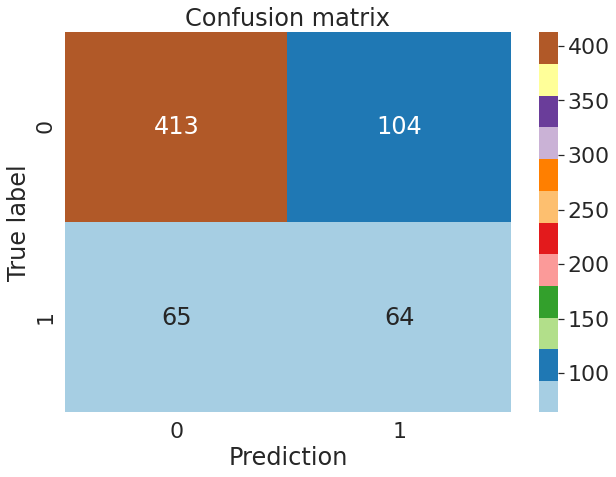

In [67]:
# plot the confution matrix with threshold = 0.5
plot_confution_matrix(testY, pred_Y, 0.5)

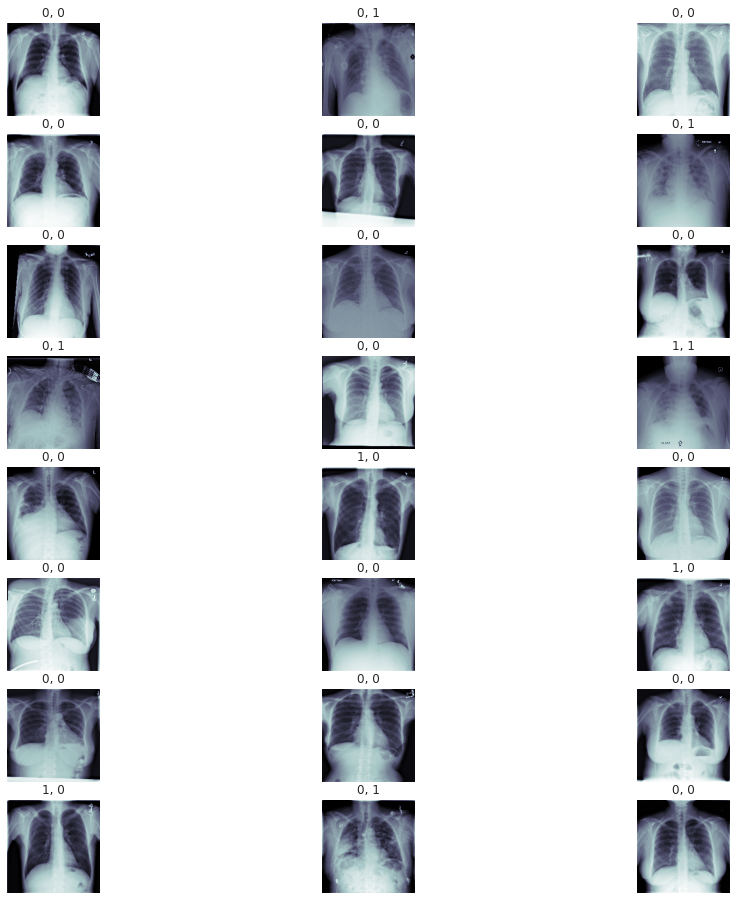

In [69]:
## Let's look at some examples of true vs. predicted with our best model: 
length = 24
threshold = 0.5
sns.set(font_scale=1)
pred_Y = my_model.predict(testX[0:length])
fig, m_axs = plt.subplots(8, 3, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:length], testY[0:length], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [107]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)